In [1]:
from PIL import Image, ImageDraw, ImageFont, ImageOps
from skimage import transform
from scipy.ndimage import rotate
from mat4py import loadmat
import numpy as np
import random
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import imgaug.augmenters as iaa
from tqdm import tqdm
import os

In [2]:
COCO = 'E:/Datasets/COCO/train2014'
bg_images = os.listdir(COCO)
bg_images = ['{}/{}'.format(COCO, f) for f in bg_images if f.endswith('.jpg')]

## Create template

In [3]:
N3_LICENSE_SYMBOL = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
N4_LICENSE_SYMBOL = '0123456789012345678901234567890123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'

PLATE_WIDTH = 190
PLATE_HEIGHT = 140
PLATE_COLOR_MAX = [254, 254, 254]
PLATE_COLOR_MIN = [245, 245, 235]
PLATE_NUMBER_FONT = ImageFont.truetype('./Soxe2banh-v2.ttf', 62)
PLATE_NUMBER_COLOR_MAX = [30, 30, 30]
PLATE_NUMBER_COLOR_MIN = [0, 0, 0]

IMAGE_SIZE = (512, 512)
ROTATE_X_MAX = 10
ROTATE_Y_MAX = 10
ROTATE_Z_MAX = 10
# TRANSLATE_X_MAX = 50
# TRANSLATE_Y_MAX = 50
# TRANSLATE_Z_MAX = 50
TRANSLATE_X_MAX = 0
TRANSLATE_Y_MAX = 0
TRANSLATE_Z_MAX = 0

augmentor = iaa.Sometimes(0.8,[
                            iaa.Affine(scale=(0.8, 1.4), translate_percent={'x': (-0.2, 0.2), 'y': (-0.2, 0.2)}),
                            iaa.OneOf([
                               iaa.FastSnowyLandscape(lightness_multiplier=2.0),
                               iaa.Clouds(),
                               iaa.Fog(),
                               iaa.GammaContrast(gamma=3.0),
                               iaa.MotionBlur(k=15),
                               iaa.CoarseDropout(p=0.2, size_percent=1.0),
                               iaa.CoarseDropout(p=0.2, size_percent=1.0, per_channel=True),
                               iaa.JpegCompression(compression=99)
                       ])])


def random_license_number():
    n1 = np.random.randint(0, 10)
    n2 = np.random.randint(0, 10)
    n3 = random.choice(N3_LICENSE_SYMBOL)
    n4 = random.choice(N4_LICENSE_SYMBOL)
    n5 = np.random.randint(0, 10)
    n6 = np.random.randint(0, 10)
    n7 = np.random.randint(0, 10)
    n8 = np.random.randint(0, 10)
    n9 = np.random.randint(0, 10)
    return '{}{}_{}{}\n{}{}{}.{}{}'.format(n1, n2, n3, n4, n5, n6, n7, n8, n9)

def create_plate(number):
    plate_color = (np.random.randint(PLATE_COLOR_MIN[0], PLATE_COLOR_MAX[0]),
                  np.random.randint(PLATE_COLOR_MIN[1], PLATE_COLOR_MAX[1]),
                  np.random.randint(PLATE_COLOR_MIN[2], PLATE_COLOR_MAX[2]))
    image = Image.new('RGB', (PLATE_WIDTH, PLATE_HEIGHT), plate_color)
    d = ImageDraw.Draw(image)
    d.line([(0, 0), (PLATE_WIDTH - 1, 0), (PLATE_WIDTH - 1, PLATE_HEIGHT - 1), (0, PLATE_HEIGHT - 1), (0, 0)], fill=(0, 0, 0), width=10, joint='curve')
    plate_number_color = (np.random.randint(PLATE_NUMBER_COLOR_MIN[0], PLATE_NUMBER_COLOR_MAX[0]),
                  np.random.randint(PLATE_NUMBER_COLOR_MIN[1], PLATE_NUMBER_COLOR_MAX[1]),
                  np.random.randint(PLATE_NUMBER_COLOR_MIN[2], PLATE_NUMBER_COLOR_MAX[2]))
    d.multiline_text([4, 13], number, font=PLATE_NUMBER_FONT, fill=plate_number_color, align='center')
    
    return image

def rotate_along_axis(image, theta=0, phi=0, gamma=0, dx=0, dy=0, dz=0):
    
    width, height = np.shape(image)[:2]

    # Get radius of rotation along 3 axes
    theta, phi, gamma = np.deg2rad([theta, phi, gamma])

    # Get ideal focal length on z axis
    # NOTE: Change this section to other axis if needed
    d = np.sqrt(height**2 + width**2)
    focal = d / (2 * np.sin(gamma) if np.sin(gamma) != 0 else 1)
    dz = focal
        
    # Projection 2D -> 3D matrix
    A1 = np.array([ [1, 0, -width/2],
                    [0, 1, -height/2],
                    [0, 0, 1],
                    [0, 0, 1]])

    # Rotation matrices around the X, Y, and Z axis
    RX = np.array([ [1, 0, 0, 0],
                    [0, np.cos(theta), -np.sin(theta), 0],
                    [0, np.sin(theta), np.cos(theta), 0],
                    [0, 0, 0, 1]])

    RY = np.array([ [np.cos(phi), 0, -np.sin(phi), 0],
                    [0, 1, 0, 0],
                    [np.sin(phi), 0, np.cos(phi), 0],
                    [0, 0, 0, 1]])

    RZ = np.array([ [np.cos(gamma), -np.sin(gamma), 0, 0],
                    [np.sin(gamma), np.cos(gamma), 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]])

    # Composed rotation matrix with (RX, RY, RZ)
    R = np.dot(np.dot(RX, RY), RZ)

    # Translation matrix
    T = np.array([  [1, 0, 0, dx],
                    [0, 1, 0, dy],
                    [0, 0, 1, dz],
                    [0, 0, 0, 1]])

    # Projection 3D -> 2D matrix
    A2 = np.array([ [focal, 0, width/2, 0],
                    [0, focal, height/2, 0],
                    [0, 0, 1, 0]])

    # Final transformation matrix
    M = np.dot(A2, np.dot(T, np.dot(R, A1)))
        
    return transform.warp(image, M, mode='edge', preserve_range=True)

def convert_white_to_transparent(image):
    new_image = []
    for pixel in image.getdata():
        if pixel == (255, 255, 255, 255):
            new_image.append((255, 255, 255, 0))
        else:
            new_image.append(pixel)
    image.putdata(new_image)
    return image

def add_noise(image):
    image = np.array(image)
    image = augmentor.augment_image(image)
    return image

def add_random_bg(image):
    image = ImageOps.expand(image, border=200, fill='white')
    image = image.convert('RGBA')
    image = convert_white_to_transparent(image)
    idx = np.random.randint(0, len(bg_images))
    path = bg_images[idx]
    bg_image = Image.open(path)
    bg_image = bg_image.resize(IMAGE_SIZE, Image.ANTIALIAS)
    bg_image.paste(image, (0, 0), image)
    image = bg_image
    
    image = np.array(image)
    r_theta = np.random.randint(-ROTATE_X_MAX, ROTATE_X_MAX)
    r_phi = np.random.randint(-ROTATE_Y_MAX, ROTATE_Y_MAX)
    r_gamma = np.random.randint(-ROTATE_Z_MAX, ROTATE_Z_MAX)
    r_dx = 50
    r_dy = 50
    r_dz = 0
    image = rotate_along_axis(image, theta=r_theta, phi=r_phi, gamma=r_gamma, dx=r_dx, dy=r_dy, dz=r_dz)
    image = image.astype(np.uint8)
    image = Image.fromarray(image)
    
    return image

(512, 512, 3)


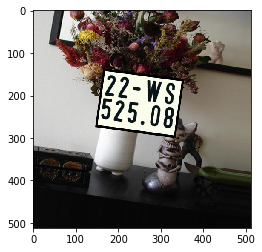

In [26]:
n = random_license_number()
a = create_plate(n)
b = add_random_bg(a)
b = add_noise(b)
print(b.shape)
plt.imshow(b)
plt.show()

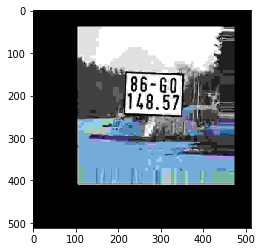

In [471]:
s = b
x = iaa.OneOf([
        iaa.Affine(scale=(0.8, 1.2)),
#         iaa.FastSnowyLandscape(lightness_multiplier=2.0),
#         iaa.Clouds(),
#         iaa.Fog(),
#         iaa.GammaContrast(gamma=3.0),
#         iaa.MotionBlur(k=20),
#         iaa.CoarseDropout(p=0.2, size_percent=1.0),
    ])
s = x.augment_image(s)
plt.imshow(s)
plt.show()

## Generate license plates

In [5]:
NUM_OF_SAMPLE = 50000
SAVE_DIR_1 = 'E:/Datasets/Vietnamese Motorbike License Plate/license_plate'

In [505]:

for i in tqdm(range(NUM_OF_SAMPLE)):
    license = random_license_number()
    image = create_plate(license)
    image.save('{}/{}.jpg'.format(SAVE_DIR_1, license.replace('_', '').replace('\n', '').replace('.', '')))

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:33<00:00, 233.92it/s]


## Generate license plates in scene

In [6]:
license_plates = os.listdir(SAVE_DIR_1)
license_plates = [f for f in license_plates if f.endswith('.jpg')]
SAVE_DIR_2 = 'E:/Datasets/Vietnamese Motorbike License Plate/images'

generated = os.listdir(SAVE_DIR_2)
license_plates = [f for f in license_plates if f not in generated]

for plate in tqdm(license_plates):
    image = Image.open('{}/{}'.format(SAVE_DIR_1, plate))
    image = add_random_bg(image)
    while True:
        try:
            image = add_noise(image)
            break
        except:
            pass
    image = Image.fromarray(image)
    image.save('{}/{}'.format(SAVE_DIR_2, plate))

100%|██████████████████████████████████████████████████████████████████████████| 45424/45424 [3:41:58<00:00,  2.79it/s]


In [6]:
SAVE_DIR_2 = 'E:/Datasets/Vietnamese Motorbike License Plate/images'

In [10]:
from tqdm import tqdm
import os

In [16]:
for file in tqdm(os.listdir(SAVE_DIR_1)):
    a = file.split('.jpg')[0]
    a = a.replace('-', '').replace('.', '')
    a = a + '.jpg'
    os.rename(SAVE_DIR_1 + '/' + file, SAVE_DIR_1 + '/' + a)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 860.10it/s]
